In [402]:
# Data in this project comes from https://github.com/JeffSackmann/tennis_atp

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import keras_tuner as kt
import joblib

## Preparing features, target

In [2]:
# Splitting data into features and target.
train_data = pd.read_csv('../data/03_processed_data/clean_train_data.csv')
test_data = pd.read_csv('../data/03_processed_data/clean_test_data.csv')

def split_and_normalize(df, fit_on_train_data=True, scaler=None):
    # Shuffling rows in random order.
    df = df.sample(frac = 1, random_state=42)
    y = df['result'].reset_index(drop=True)
    X = df.iloc[:, 1:]

    # Using normalization instead of standarization because some features aren't normally distributed.
    if fit_on_train_data:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        return X_scaled, y, scaler
    else:
        X_scaled = scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        return X_scaled, y


X_train, y_train, my_scaler = split_and_normalize(train_data)
X_test, y_test = split_and_normalize(test_data, False, my_scaler)

In [37]:
train_data.describe()

,result,ht_p12,age_p12,rank_points_p12,home_adv_p12,hand_p12,entry_p12,matches_5yrs_p12,wins_5yrs_p12,ratio_5yrs_p12,...,surface_matches_5yrs_p12,surface_wins_5yrs_p12,surface_ratio_5yrs_p12,direct_wins_5yrs_p12,tourney_5yrs_p12,3_mths_matches_p12,3_mths_elo_p12,3_mths_wins_p12,previous_minutes_p12,how_long_brake_p12
count,52926.000000,52926.000000,5.292600e+04,52926.000000,52926.000000,52926.000000,52926.000000,52926.000000,52926.000000,5.292600e+04,...,52926.000000,52926.000000,5.292600e+04,52926.000000,52926.000000,52926.000000,5.292600e+04,52926.000000,52926.000000,52926.000000
mean,0.500000,0.000000,-1.678151e-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.810295e-20,...,0.000000,0.000000,1.468382e-20,0.000000,0.000000,0.000000,-4.493838e-16,0.000000,0.000000,0.000000
std,0.500005,9.459666,5.353387e+00,2651.923785,0.445542,0.471783,0.454983,101.686184,73.948315,1.784141e-01,...,52.840746,39.117926,1.883158e-01,1.207284,2.608753,6.003214,5.034369e+01,4.335548,50.067167,129.922005
min,0.000000,-41.000000,-2.090000e+01,-16641.000000,-1.000000,-1.000000,-1.000000,-345.000000,-308.000000,-8.716418e-01,...,-231.000000,-212.000000,-8.167939e-01,-12.000000,-15.000000,-33.000000,-3.647365e+02,-29.000000,-419.000000,-3059.000000
25%,0.000000,-5.000000,-3.600000e+00,-769.000000,0.000000,0.000000,0.000000,-69.000000,-35.000000,-1.051480e-01,...,-29.000000,-14.000000,-1.040037e-01,0.000000,0.000000,-3.000000,-1.568882e+01,-1.000000,-4.000000,0.000000
50%,0.500000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-7.771561e-16,0.000000,0.000000,0.000000
75%,1.000000,5.000000,3.600000e+00,769.000000,0.000000,0.000000,0.000000,69.000000,35.000000,1.051480e-01,...,29.000000,14.000000,1.040037e-01,0.000000,0.000000,3.000000,1.568882e+01,1.000000,4.000000,0.000000
max,1.000000,41.000000,2.090000e+01,16641.000000,1.000000,1.000000,1.000000,345.000000,308.000000,8.716418e-01,...,231.000000,212.000000,8.167939e-01,12.000000,15.000000,33.000000,3.647365e+02,29.000000,419.000000,3059.000000


## Logistic regression and general functions for evaluation

,Feature,Coefficient,Odds Ratio
0,how_long_brake_p12,-8.406044,0.000224
1,rank_points_p12,4.357437,78.056833
2,ratio_pts_3yrs_p12,3.482033,32.525787
3,surface_matches_5yrs_p12,3.303494,27.207532
4,surface_wins_5yrs_p12,-2.957708,0.051938
5,3_mths_matches_p12,2.914091,18.432052
6,wins_5yrs_p12,-2.831092,0.058948
7,matches_5yrs_p12,2.490094,12.062405
8,surface_ratio_5yrs_p12,2.068940,7.916424
9,age_p12,-1.995882,0.135894


,rank_points_p12,matches_5yrs_p12,wins_5yrs_p12,ratio_5yrs_p12,ratio_svpt_3yrs_p12,ratio_pts_3yrs_p12,surface_matches_5yrs_p12,surface_wins_5yrs_p12,surface_ratio_5yrs_p12,3_mths_matches_p12,3_mths_wins_p12
rank_points_p12,NaN,NaN,0.758876,NaN,NaN,0.700926,NaN,NaN,NaN,NaN,NaN
matches_5yrs_p12,NaN,NaN,0.879252,0.736462,NaN,0.714948,0.882757,0.771298,NaN,NaN,NaN
wins_5yrs_p12,0.758876,0.879252,NaN,0.857803,NaN,0.841718,0.779825,0.847703,NaN,NaN,NaN
ratio_5yrs_p12,NaN,0.736462,0.857803,NaN,NaN,0.902872,NaN,0.729181,0.808330,NaN,NaN
ratio_svpt_3yrs_p12,NaN,NaN,NaN,NaN,NaN,0.702352,NaN,NaN,NaN,NaN,NaN
ratio_pts_3yrs_p12,0.700926,0.714948,0.841718,0.902872,0.702352,NaN,NaN,0.719587,0.735322,NaN,NaN
surface_matches_5yrs_p12,NaN,0.882757,0.779825,NaN,NaN,NaN,NaN,0.892590,NaN,NaN,NaN
surface_wins_5yrs_p12,NaN,0.771298,0.847703,0.729181,NaN,0.719587,0.892590,NaN,0.760167,NaN,NaN
surface_ratio_5yrs_p12,NaN,NaN,NaN,0.808330,NaN,0.735322,NaN,0.760167,NaN,NaN,NaN
3_mths_matches_p12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.740677


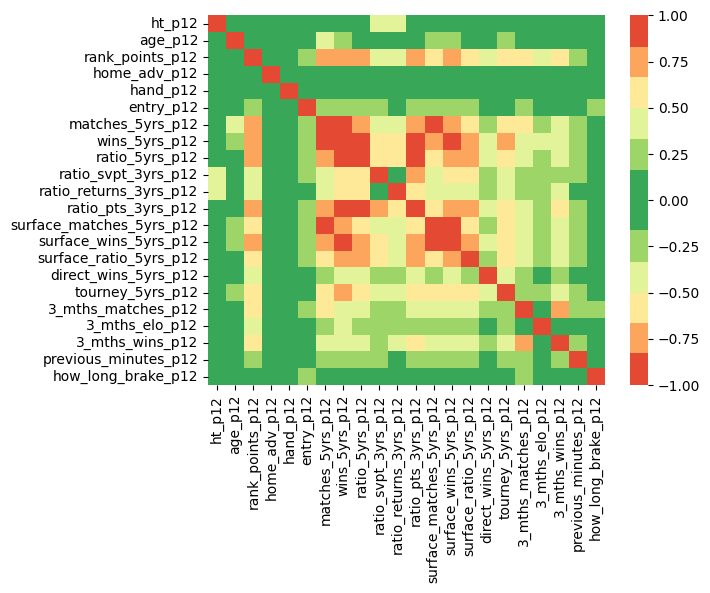

In [28]:
# Creating functions to train and evaluate model and also compare it with different model.

# Creating and training logistic regression model and checking coefficients for every feature. The model will be without intercept because 
# using intercept would favor one of 2 players and model would perform better or worse depeding on the order of the players put into equation.
def train_and_coefficients(X_train, y_train, C=1):
    log_reg = LogisticRegression(random_state=42, fit_intercept=False, C=C, max_iter=5000)
    log_reg.fit(X_train, y_train)
    w = np.array(log_reg.coef_).transpose()

    coefficients = log_reg.coef_
    odds_ratios = np.exp(coefficients)
    coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients[0], 'Odds Ratio': odds_ratios[0]})
    coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index).reset_index(drop=True)
    display(coefficients_df)

    return log_reg, w

# Viewing correlation matrix and correlation heatmap:
def view_corr(X_train, treshold=0.7):
    correlation_matrix = X_train.corr()
    # Viewing only strongly correlated features.
    condition = ((correlation_matrix >= treshold) & (correlation_matrix < 1)) | ((correlation_matrix <= -treshold) & (correlation_matrix > -1))
    high_correlation_rows = correlation_matrix[condition].dropna(how='all')
    high_correlation_rows.dropna(axis=1, how='all', inplace=True)
    display(high_correlation_rows)
    # Viewing all features on heatmap.
    mypal = sns.color_palette('RdYlGn') + sns.color_palette('RdYlGn_r')
    sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap=mypal, center=0)
    plt.show()

# Removing features.
def remove_feature(X_train, X_test, features):
    new_X_test = X_test.copy()
    new_X_test.drop(features, axis=1, inplace=True)
    new_X_train = X_train.copy()
    new_X_train.drop(features, axis=1, inplace=True)
    return new_X_train, new_X_test

# Calculating logaritmic loss and ROC.
def log_loss_and_roc(model, X, y):
    # Predictions
    y_pred = model.predict_proba(X)[:, 1]
    # Logaritmic loss:
    loss = log_loss(y, y_pred)
    # Area Under the Curve
    auc = roc_auc_score(y, y_pred)
    return loss, auc

# Function to divide train dataset into x folds and carry out cross-validation.
# Alternatively I could use 2 cross_val_score functions with different scoring - there would be less code but execution time would be twice as long.
def cross_validation(model, X, y, cv=5):
    skfolds = StratifiedKFold(n_splits=cv)
    cross_accuracy = []
    cross_log_loss = []
    for train_index, test_index in skfolds.split(X, y):
        clone_clf = clone(model)
        X_train_folds = X.iloc[train_index, :]
        y_train_folds = y.iloc[train_index]
        X_test_fold = X.iloc[test_index, :]
        y_test_fold = y.iloc[test_index]
        clone_clf.fit(X_train_folds, y_train_folds)
        # Accuracy:
        cross_accuracy.append(clone_clf.score(X_test_fold, y_test_fold))
        # Logaritmic loss:
        y_pred = clone_clf.predict_proba(X_test_fold)[:, 1]
        cross_log_loss.append(log_loss(y_test_fold, y_pred))
    return [np.array(cross_accuracy), np.array(cross_log_loss)]

def full_log_likelihood(w, X, y):
    score = np.dot(X, w).reshape(-1)
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def null_log_likelihood(y_true):
    p = np.mean(y_true)
    return np.sum(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

# Evaluating model with McFadden's adjusted-R-squared.
def mcfadden_adjusted_rsquare(w, X, y):
    k = float(X.shape[1])
    mcfadden = 1.0 - ((full_log_likelihood(w, X, y) - k) / null_log_likelihood(y))
    return mcfadden
      
# Compering 2 models by accuracy, logistic loss, AUC (and McFadden's adjusted-R-square if it is logistic regression).
def compare_models(models, Xs, y, w=None, log_reg=False, count_of_models=2):
    eval_dict = {}
    for i in range(count_of_models):
        mod_accuracy = models[i].score(Xs[i], y)
        mod_loss, mod_auc = log_loss_and_roc(models[i], Xs[i], y)
        mod_cross = cross_validation(models[i], Xs[i], y)
        # Formatting np.arrays to exacly 4 digits for increased readibility.
        full_cross_scoring = []
        for scoring in mod_cross:
            full_cross_scoring.append(', '.join([f'{i:.4f}' for i in scoring]))
        # Printing scores for cross-validation.
        print(f'Model {i+1} (cross-val): accuracy = [{full_cross_scoring[0]}], log loss = [{full_cross_scoring[1]}]')
        # Constructing dictionary with scores that will be displayed as DataFrame.
        eval_data = [mod_accuracy, mod_loss, mod_auc, mod_cross[0].mean(), mod_cross[0].std(), mod_cross[1].mean(), mod_cross[1].std()]
        if log_reg:
            eval_data.append(mcfadden_adjusted_rsquare(w[i], Xs[i], y))
        eval_dict[f'Model {i+1}'] = eval_data

    models_df = pd.DataFrame(eval_dict)
    models_df.index = ['Accuracy', 'Logistic loss', 'AUC', 'Average accuracy (cross-val)', 'Std accuracy (cross-val)',
                       'Average log loss (cross-val)', 'Std log loss (cross-val)', "McFadden's adjusted-R-squared"][:len(models_df)]
    display(models_df.round(4))

# Training first model.
log_reg0, w0 = train_and_coefficients(X_train, y_train)

# Correlation matrix.
view_corr(X_train)

,Feature,Coefficient,Odds Ratio
0,how_long_brake_p12,-9.109413,0.000111
1,rank_points_p12,3.471004,32.169012
2,3_mths_matches_p12,2.631646,13.896625
3,matches_5yrs_p12,2.568385,13.044744
4,surface_ratio_5yrs_p12,2.066135,7.894252
5,previous_minutes_p12,-1.982035,0.137789
6,age_p12,-1.961288,0.140677
7,ratio_svpt_3yrs_p12,1.134047,3.108211
8,tourney_5yrs_p12,0.837222,2.309941
9,ratio_returns_3yrs_p12,0.509254,1.664049


,rank_points_p12,matches_5yrs_p12
rank_points_p12,NaN,0.68522
matches_5yrs_p12,0.68522,NaN


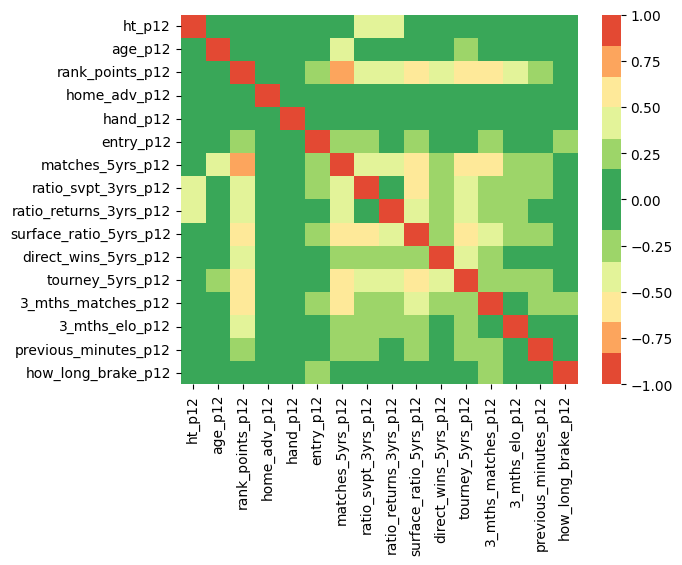

In [29]:
# It looks like ratio features work well only in point based features but poorly in match based features.
# In match based features it turns out that count of wins or matches played by player is more importent that good ratio.
# It makes sense because tournaments are always played in play-off system so the better player will always play more matches.
# After testing different combinations I removed features in a way to balance minimizing correlation and maximizing model performance.
# I decided to leave both 'rank_points_p12' and 'matches_5yrs_p12' in the model despite quite high correlation because in theory
# those features are very different because 'matches_5yrs_p12' doesn't take into considerantion tournament's prestige.
# (also it is below 0.7 so this correlation is acceptable)
X_train_log_reg, X_test_log_reg = remove_feature(X_train, X_test, ['ratio_5yrs_p12', 'wins_5yrs_p12', 'surface_wins_5yrs_p12',
                                                                   'surface_matches_5yrs_p12', '3_mths_wins_p12', 'ratio_pts_3yrs_p12'])

# Training second model.
log_reg1, w1 = train_and_coefficients(X_train_log_reg, y_train)

# Correlation matrix.
view_corr(X_train_log_reg, treshold=0.65)

In [36]:
# The next step was testing different periods (YEARS and MONTHS) and limits in features created in data engineering. I already set optimal values.
# (limits of 4 years and 5 years were very similar).

# In the model there is a few features with very low coeffintients. Let's try removing them one by one and check new results.
# Removing ['ht_p12', '3_mths_elo_p12', 'home_adv_p12', 'hand_p12'] made almost no difference, 
# Removing further features caused model to be worse, so I decided to remove only those 4 features.
X_train_log_reg2, X_test_log_reg2 = remove_feature(X_train_log_reg, X_test_log_reg, ['ht_p12', '3_mths_elo_p12', 'home_adv_p12', 'hand_p12'])

# Training another model.
log_reg2, w2 = train_and_coefficients(X_train_log_reg2, y_train)

# Comparing new model with previous model (without correlation).
compare_models([log_reg1, log_reg2], [X_train_log_reg, X_train_log_reg2], y_train, [w1, w2], True)

,Feature,Coefficient,Odds Ratio
0,how_long_brake_p12,-8.910253,0.000135
1,rank_points_p12,3.442575,31.267366
2,matches_5yrs_p12,2.580073,13.198100
3,3_mths_matches_p12,2.566007,13.013762
4,surface_ratio_5yrs_p12,2.073447,7.952187
5,age_p12,-1.978701,0.138249
6,previous_minutes_p12,-1.973554,0.138962
7,ratio_svpt_3yrs_p12,1.236726,3.444320
8,tourney_5yrs_p12,0.786515,2.195732
9,direct_wins_5yrs_p12,-0.499740,0.606688


Model 1 (cross-val): accuracy = [0.6859, 0.6836, 0.6874, 0.6900, 0.6803], log loss = [0.5835, 0.5865, 0.5861, 0.5877, 0.5871]
Model 2 (cross-val): accuracy = [0.6869, 0.6843, 0.6873, 0.6896, 0.6811], log loss = [0.5835, 0.5868, 0.5861, 0.5880, 0.5873]


,Model 1,Model 2
Accuracy,0.6853,0.6861
Logistic loss,0.5859,0.5861
AUC,0.7553,0.7550
Average accuracy (cross-val),0.6854,0.6858
Std accuracy (cross-val),0.0033,0.0029
Average log loss (cross-val),0.5862,0.5863
Std log loss (cross-val),0.0014,0.0016
McFadden's adjusted-R-squared,0.1543,0.1541


In [31]:
# Regularization.
# Testing different C values with grid search method.
params_grid = {'C': [0.1, 0.5] + list(range(1, 51))}

def best_C(my_scoring):
    grid_search = GridSearchCV(LogisticRegression(random_state=42, fit_intercept=False), params_grid, cv=5, scoring=my_scoring)
    grid_search.fit(X_train_log_reg2, y_train)
    best_C = grid_search.best_params_['C']
    print(best_C)

best_C('accuracy')
best_C('neg_log_loss')

6
5


In [31]:
# Comparing models with C=1 and with C=38 (best options from previous step).
log_reg_C6, w_C6 = train_and_coefficients(X_train_log_reg2, y_train, C=6)
log_reg_C5, w_C5 = train_and_coefficients(X_train_log_reg2, y_train, C=5)
compare_models([log_reg_C6, log_reg_C5], [X_train_log_reg2, X_train_log_reg2], y_train, [w_C6, w_C5], True)

,Feature,Coefficient,Odds Ratio
0,how_long_brake_p12,-9.617728,0.000067
1,rank_points_p12,3.713125,40.981694
2,3_mths_matches_p12,2.633738,13.925730
3,matches_5yrs_p12,2.487496,12.031115
4,surface_ratio_5yrs_p12,2.068079,7.909613
5,age_p12,-1.929538,0.145215
6,previous_minutes_p12,-1.827115,0.160877
7,ratio_svpt_3yrs_p12,1.288849,3.628606
8,tourney_5yrs_p12,0.827263,2.287051
9,ratio_returns_3yrs_p12,0.530367,1.699556


,Feature,Coefficient,Odds Ratio
0,how_long_brake_p12,-9.583692,0.000069
1,rank_points_p12,3.700272,40.458300
2,3_mths_matches_p12,2.630878,13.885957
3,matches_5yrs_p12,2.492443,12.090776
4,surface_ratio_5yrs_p12,2.068357,7.911817
5,age_p12,-1.932393,0.144801
6,previous_minutes_p12,-1.834615,0.159675
7,ratio_svpt_3yrs_p12,1.286065,3.618519
8,tourney_5yrs_p12,0.825333,2.282641
9,ratio_returns_3yrs_p12,0.528578,1.696519


Model 1 (cross-val): accuracy = [0.6869, 0.6853, 0.6885, 0.6890, 0.6794], log loss = [0.5833, 0.5868, 0.5858, 0.5879, 0.5872]
Model 2 (cross-val): accuracy = [0.6867, 0.6849, 0.6891, 0.6886, 0.6795], log loss = [0.5833, 0.5868, 0.5858, 0.5879, 0.5872]


,Model 1,Model 2
Accuracy,0.6856,0.6857
Logistic loss,0.5860,0.5860
AUC,0.7553,0.7553
Average accuracy (cross-val),0.6858,0.6858
Std accuracy (cross-val),0.0035,0.0034
Average log loss (cross-val),0.5862,0.5862
Std log loss (cross-val),0.0016,0.0016
McFadden's adjusted-R-squared,0.1543,0.1543


In [208]:
# Model with C=5 is slightly better.
# Saving model log_reg_C5.
joblib.dump(log_reg_C5, '../models/trained_logistic_regression_model.pkl')

['../models/trained_logistic_regression_model.pkl']

## Random forest

In [12]:
# Regularization.
# Testing different parameters with random search method (grid search method is too computationally complex for random forest).

# I'm using features from X_train_log_reg - so all features minus features that were strongly correlated. So for now I'm also using features
# that had really low coeffitients in logistic regression. I'll remove appropriate features after checking feature importance in random forest.
param_distribs = {
                  'max_depth': randint(low=7, high=9),
                  'min_samples_leaf': randint(low=130, high=170)
                  }

def best_params(X, my_n_iter, my_scoring='neg_log_loss'):
    rnd_search = RandomizedSearchCV(RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1), param_distributions=param_distribs, cv=5,
                                    n_iter=my_n_iter, scoring=my_scoring, random_state=42)
    rnd_search.fit(X, y_train)
    cv_results = rnd_search.cv_results_
    results_df = pd.DataFrame(cv_results)
    top_10 = results_df[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).reset_index(drop=True).head(10)
    display(top_10)
    return rnd_search.best_params_, top_10.loc[1, 'params']

pd.set_option('display.max_colwidth', 80)

# For now I'm using the same features as in the best logistic regression model.
log_loss_best_params, log_loss_second_params = best_params(X_train_log_reg, 50)

,params,mean_test_score,std_test_score
0,"{'max_depth': 8, 'min_samples_leaf': 135}",-0.583880,0.001529
1,"{'max_depth': 8, 'min_samples_leaf': 133}",-0.583889,0.001579
2,"{'max_depth': 8, 'min_samples_leaf': 131}",-0.583895,0.001550
3,"{'max_depth': 8, 'min_samples_leaf': 131}",-0.583895,0.001550
4,"{'max_depth': 8, 'min_samples_leaf': 131}",-0.583895,0.001550
5,"{'max_depth': 8, 'min_samples_leaf': 137}",-0.583935,0.001533
6,"{'max_depth': 8, 'min_samples_leaf': 138}",-0.583967,0.001517
7,"{'max_depth': 8, 'min_samples_leaf': 144}",-0.583984,0.001545
8,"{'max_depth': 8, 'min_samples_leaf': 143}",-0.583992,0.001526
9,"{'max_depth': 8, 'min_samples_leaf': 143}",-0.583992,0.001526


In [13]:
# Function to create and train random forest model.
def train_forest(X, y, params_variable):
    model = RandomForestClassifier(n_estimators=300, max_depth=params_variable['max_depth'],
                                    min_samples_leaf=params_variable['min_samples_leaf'], n_jobs=-1, random_state=42)
    model.fit(X, y)
    return model

# Training and comparing 2 best models from previous step.
best_random_forest = train_forest(X_train_log_reg, y_train, log_loss_best_params)
second_random_forest = train_forest(X_train_log_reg, y_train, log_loss_second_params)
compare_models([best_random_forest, second_random_forest], [X_train_log_reg, X_train_log_reg], y_train)

Model 1 (cross-val): accuracy = [0.6877, 0.6829, 0.6873, 0.6938, 0.6819], log loss = [0.5810, 0.5851, 0.5837, 0.5848, 0.5848]
Model 2 (cross-val): accuracy = [0.6874, 0.6835, 0.6877, 0.6932, 0.6814], log loss = [0.5809, 0.5852, 0.5837, 0.5847, 0.5849]


,Model 1,Model 2
Accuracy,0.6947,0.6950
Logistic loss,0.5741,0.5741
AUC,0.7688,0.7689
Average accuracy (cross-val),0.6867,0.6867
Std accuracy (cross-val),0.0042,0.0041
Average log loss (cross-val),0.5839,0.5839
Std log loss (cross-val),0.0015,0.0016


In [14]:
# Function for determing feature importance.
def feature_importance(model, X):
    df_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
    df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)
    display(df_feature_importances.reset_index(drop=True))

# Feature importance for the best random forest model. I picked model 1 because it was better in almost every aspect.
feature_importance(best_random_forest, X_train_log_reg)

,Feature,Importance
0,rank_points_p12,0.352696
1,matches_5yrs_p12,0.161474
2,surface_ratio_5yrs_p12,0.160617
3,3_mths_matches_p12,0.135061
4,ratio_svpt_3yrs_p12,0.061033
5,tourney_5yrs_p12,0.039798
6,ratio_returns_3yrs_p12,0.028385
7,age_p12,0.026310
8,3_mths_elo_p12,0.008617
9,direct_wins_5yrs_p12,0.007808


In [15]:
# Because of the very low importance of some of the features I remove 2 lowest and once more try to find the best parameters.
X_train_forest, X_test_forest = remove_feature(X_train_log_reg, X_test_log_reg, ['home_adv_p12', 'hand_p12'])
log_loss_best_params2, log_loss_second_params2 = best_params(X_train_forest, 50)

,params,mean_test_score,std_test_score
0,"{'max_depth': 8, 'min_samples_leaf': 131}",-0.584361,0.001545
1,"{'max_depth': 8, 'min_samples_leaf': 131}",-0.584361,0.001545
2,"{'max_depth': 8, 'min_samples_leaf': 131}",-0.584361,0.001545
3,"{'max_depth': 8, 'min_samples_leaf': 133}",-0.584389,0.001556
4,"{'max_depth': 8, 'min_samples_leaf': 137}",-0.584399,0.001591
5,"{'max_depth': 8, 'min_samples_leaf': 135}",-0.584418,0.001547
6,"{'max_depth': 8, 'min_samples_leaf': 138}",-0.584421,0.001586
7,"{'max_depth': 8, 'min_samples_leaf': 144}",-0.584427,0.001550
8,"{'max_depth': 8, 'min_samples_leaf': 143}",-0.584436,0.001564
9,"{'max_depth': 8, 'min_samples_leaf': 143}",-0.584436,0.001564


In [16]:
# Training and comparing 2 best models from previous step.
best_random_forest2 = train_forest(X_train_forest, y_train, log_loss_best_params2)
second_random_forest2 = train_forest(X_train_forest, y_train, log_loss_second_params2)
compare_models([best_random_forest2, second_random_forest2], [X_train_forest, X_train_forest], y_train)

Model 1 (cross-val): accuracy = [0.6887, 0.6846, 0.6875, 0.6949, 0.6814], log loss = [0.5814, 0.5856, 0.5842, 0.5850, 0.5856]
Model 2 (cross-val): accuracy = [0.6887, 0.6846, 0.6875, 0.6949, 0.6814], log loss = [0.5814, 0.5856, 0.5842, 0.5850, 0.5856]


,Model 1,Model 2
Accuracy,0.6946,0.6946
Logistic loss,0.5747,0.5747
AUC,0.7686,0.7686
Average accuracy (cross-val),0.6874,0.6874
Std accuracy (cross-val),0.0045,0.0045
Average log loss (cross-val),0.5844,0.5844
Std log loss (cross-val),0.0015,0.0015


In [17]:
# Feature importance for the best random forest model. I picked model 'best_random_forest2' because it has the samallest
# logistic loss on cross-validation out of 4 random forest models.
feature_importance(best_random_forest2, X_train_forest)

,Feature,Importance
0,rank_points_p12,0.319606
1,matches_5yrs_p12,0.172087
2,surface_ratio_5yrs_p12,0.158431
3,3_mths_matches_p12,0.133439
4,ratio_svpt_3yrs_p12,0.064296
5,tourney_5yrs_p12,0.051799
6,ratio_returns_3yrs_p12,0.034950
7,age_p12,0.026298
8,direct_wins_5yrs_p12,0.009364
9,3_mths_elo_p12,0.008766


In [18]:
# Saving model best_random_forest2.
joblib.dump(best_random_forest2, '../models/trained_random_forest_model.pkl')

['../models/trained_random_forest_model.pkl']

## Artificial neural network

In [9]:
# Choosing features to train the model.
# I decided to remove features that weren't important at the same time in logistic regression and random forest models.
# If they weren't used in one model but were useful in the second then they will be used in ANN.
X_train_ann, X_test_ann = remove_feature(X_train_log_reg, X_test_log_reg, ['home_adv_p12', 'hand_p12'])

In [69]:
# Function to determine limits for parameters.
def build_model(hp):
    # Defining the range of values for each hyperparameter.
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=6)
    n_neurons = hp.Int('n_neurons', min_value=64, max_value=512, step=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(14,)))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Splitting train data to train and validation set.
X_part_train_ann, X_val_ann, y_part_train_ann, y_val_ann = train_test_split(X_train_ann, y_train, test_size=0.2, random_state=42)

# Looking for optimal parameters with hyperband tuner. Objective is set to minimize logistic loss on validation dataset. 
results = []
batch_sizes = [32, 64, 128, 192, 256]
for batch_size in batch_sizes:
    hyperband_tuner = kt.Hyperband(build_model, objective='val_loss', seed=42, max_epochs=15, factor=3, hyperband_iterations=3,
                                overwrite=True, directory='../models', project_name=f'training_ann_models_{batch_size}')

    # Defining the directory for TensorBoard logs.
    root_logdir = f'../models/training_ann_models_{batch_size}/tensorboard'
    tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)

    # Early stopping to halt training if no improvement is seen.
    stop_early = tf.keras.callbacks.EarlyStopping(patience=3)

    # Searching for the best parameters.
    hyperband_tuner.search(X_part_train_ann, y_part_train_ann, validation_data=(X_val_ann, y_val_ann), callbacks=[stop_early, tensorboard_cb], batch_size=batch_size)

    # Validating the best model for every batch size and saving it in the list.
    best_model = hyperband_tuner.get_best_models(num_models=1)[0]
    val_loss, val_accuracy = best_model.evaluate(X_val_ann, y_val_ann)
    results.append({'batch_size': batch_size, 'params': hyperband_tuner.get_best_hyperparameters(num_trials=1)[0], 'val_loss': val_loss, 'val_accuracy': val_accuracy})

    tf.keras.backend.clear_session()

# Printing the best results for every batch size.
for result in results:
    print(f"Batch size: {result['batch_size']}, Validation Loss: {result['val_loss']}, Validation Accuracy: {result['val_accuracy']},\nParams: {result['params'].values}")

Trial 90 Complete [00h 00m 50s]
val_loss: 0.5820775032043457

Best val_loss So Far: 0.5807796716690063
Total elapsed time: 00h 17m 54s


d:\Jakub\STUDIA 2\MAGISTERKA\tennis_project\project_env\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6817 - loss: 0.5847
Batch size: 32, Validation Loss: 0.5821666717529297, Validation Accuracy: 0.6832609176635742,
Params: {'n_hidden': 6, 'n_neurons': 288, 'learning_rate': 0.00010728903032965132, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0044'}
Batch size: 64, Validation Loss: 0.5811390280723572, Validation Accuracy: 0.6880785822868347,
Params: {'n_hidden': 5, 'n_neurons': 480, 'learning_rate': 0.0002107430910959911, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
Batch size: 128, Validation Loss: 0.5822515487670898, Validation Accuracy: 0.6830719709396362,
Params: {'n_hidden': 4, 'n_neurons': 352, 'learning_rate': 0.0003466383689316675, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0074'}
Batch size: 192, Validation Loss: 0.5821046233177185, Validation 

In [74]:
# Training new model using the best parameters from previous step and finding optimal number of epochs.
# The best model was trained on batch size = 64.
best_hyperparams = results[1]['params']
new_model_ann = hyperband_tuner.hypermodel.build(best_hyperparams)
history = new_model_ann.fit(X_part_train_ann, y_part_train_ann, epochs=25, validation_data=(X_val_ann, y_val_ann), batch_size=64)

Epoch 1/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.6581 - loss: 0.6183 - val_accuracy: 0.6783 - val_loss: 0.5897
Epoch 2/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6778 - loss: 0.5962 - val_accuracy: 0.6809 - val_loss: 0.5868
Epoch 3/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6815 - loss: 0.5913 - val_accuracy: 0.6815 - val_loss: 0.5870
Epoch 4/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6839 - loss: 0.5910 - val_accuracy: 0.6820 - val_loss: 0.5845
Epoch 5/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6821 - loss: 0.5892 - val_accuracy: 0.6833 - val_loss: 0.5846
Epoch 6/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6800 - loss: 0.5929 - val_accuracy: 0.6807 - val_loss: 0.5831
Epoch 7/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6856 - loss: 0.5877 - val_accuracy: 0.6833 - val_loss: 0.5835
Epoch 8/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6815 - loss: 0.5880 - 

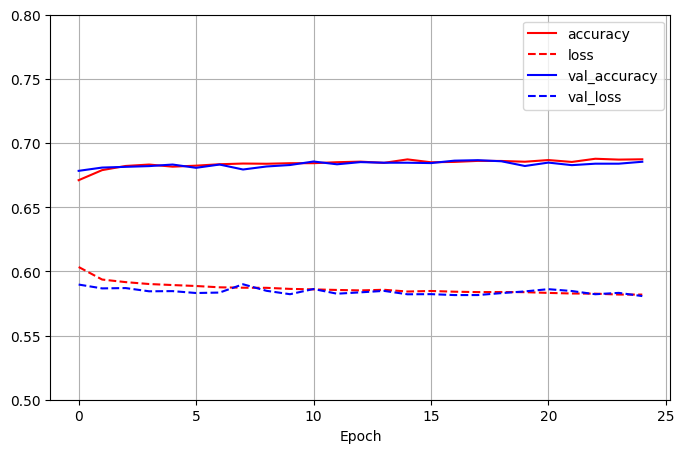

In [75]:
# Vizualization of learning process for the new ANN model.
pd.DataFrame(history.history).plot(
    figsize=(8, 5), ylim=[0.5, 0.8], grid=True, xlabel='Epoch', style=['r-', 'r--', 'b-', 'b--'])
plt.show()

In [17]:
# Train set and validation set have almost identical logistic loss on 10th epoch.
# This is why I choose to train final model for 10 epochs.
# Final model is trained on the full training dataset.
best_model_ann = hyperband_tuner.hypermodel.build(best_hyperparams)
best_model_ann.fit(X_train_ann, y_train, epochs=10, batch_size=64)
best_model_ann.save('../models/trained_neural_network_model.keras')

Epoch 1/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6544 - loss: 0.6155
Epoch 2/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6791 - loss: 0.5921
Epoch 3/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6796 - loss: 0.5901
Epoch 4/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6799 - loss: 0.5913
Epoch 5/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6842 - loss: 0.5870
Epoch 6/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6852 - loss: 0.5872
Epoch 7/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6829 - loss: 0.5868
Epoch 8/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6868 - loss: 0.5823
Epoch 9/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6854 - loss: 0.5850
Epoch 10/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6856 - loss: 0.5855


## Models evaluation

In [10]:
# Loading best  models.
best_log_reg = joblib.load('../models/trained_logistic_regression_model.pkl')
best_forest = joblib.load('../models/trained_random_forest_model.pkl')
best_model_ann = tf.keras.models.load_model('../models/trained_neural_network_model.keras')

# Testing best models on untouched test dataset and comparing it with train dataset to get final results
# and to see clearly if the models were overfitted.
def model_evaluation(model, Xs, Ys=[y_train, y_test]):
    evaluate_list = []
    for x, y in zip(Xs, Ys):
        y_pred = model.predict_proba(x)[:, 1]
        evaluate_list.append(model.score(x, y))
        evaluate_list.append(log_loss(y, y_pred))
        evaluate_list.append(roc_auc_score(y, y_pred))
    return evaluate_list

# Evaluation for logistic regression and random forest.
eval_log_reg = model_evaluation(best_log_reg, [X_train_log_reg2, X_test_log_reg2])
eval_forest = model_evaluation(best_forest, [X_train_forest, X_test_forest])

# Evaluation for neural network.
eval_ann = []
ann_evaluation_train = best_model_ann.evaluate(X_train_ann, y_train)[::-1]
eval_ann.extend(ann_evaluation_train)
y_prob_train = best_model_ann.predict(X_train_ann)
eval_ann.append(roc_auc_score(y_train, y_prob_train))
ann_evaluation_test = best_model_ann.evaluate(X_test_ann, y_test)[::-1]
eval_ann.extend(ann_evaluation_test)
y_prob_test = best_model_ann.predict(X_test_ann)
eval_ann.append(roc_auc_score(y_test, y_prob_test))

# Displaying statistics as DataFrame.
test_results = pd.DataFrame({'Logistic regression': eval_log_reg, 'Random forest': eval_forest, 'Neural network': eval_ann})
test_results.index = ['Accuracy (train)', 'Logistic loss (train)', 'AUC (train)', 'Accuracy (test)', 'Logistic loss (test)', 'AUC (test)']
display(test_results.round(3))

# Saving df to .csv file.
test_results.to_csv('../final_statistics/train_and_test_statistics.csv')

1654/1654 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6889 - loss: 0.5808
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6856 - loss: 0.5815
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Logistic regression,Random forest,Neural network
Accuracy (train),0.686,0.695,0.688
Logistic loss (train),0.586,0.575,0.582
AUC (train),0.755,0.769,0.759
Accuracy (test),0.688,0.688,0.687
Logistic loss (test),0.583,0.582,0.582
AUC (test),0.758,0.760,0.760


All 3 models achieved very similar results. However, looking at the logistic loss results on the test set, which is the most important metric  
in the context of future use of the model for betting purposes, it must be recognized that the random forest and neural network are the best  
among the models (logistic loss is more important than accuracy because we are more concerned with accurately estimating probabilities than  
predicting the winner, as betting stakes vary and depend on odds, and the best betting technique is to place bets only on those with underestimated  
probabilities). It is worth noting, however, that the random forest is the only model that has been slightly overfitted. However the difference between  
the training and test sets is below 0.01, so it is entirely acceptable. Neverthless, it would be probably safer to choose neural network model.  
Below, I present more in depth evaluation that can change this decision.

## More in depth evaluation for Master's degree project

Logistic regression

In [13]:
y_pred = best_log_reg.predict(X_test_log_reg2)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix - Logistic Regression:")
display(cm_df)

# Precision, recall, F1:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcfadden = mcfadden_adjusted_rsquare(w_C5, X_test_log_reg2, y_test)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')
print(f'McFadden Adjusted R-square: {mcfadden:.3f}')

Confusion Matrix - Logistic Regression:


,Predicted Negative,Predicted Positive
Actual Negative,4532,2072
Actual Positive,2048,4556


Precision: 0.687
Recall: 0.690
F1-score: 0.689
McFadden Adjusted R-square: 0.157


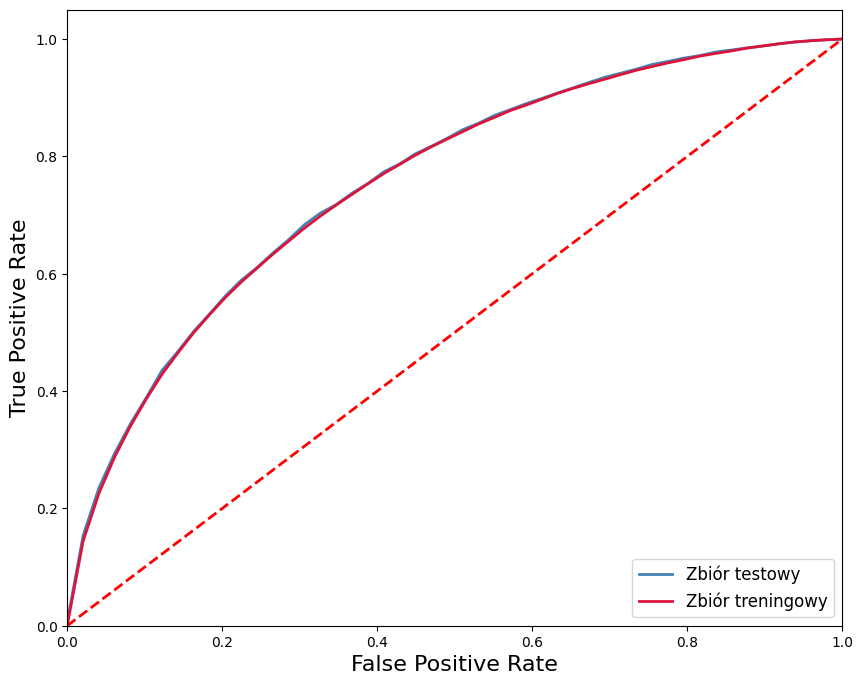

In [27]:
from scipy.interpolate import interp1d

# ROC for test and train sets

y_pred_proba = best_log_reg.predict_proba(X_test_log_reg2)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
y_pred_proba_train = best_log_reg.predict_proba(X_train_log_reg2)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)

# Interpolating points to smoothen the curve.
fpr_new = np.linspace(fpr.min(), fpr.max(), 50)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_new)
fpr_new_train = np.linspace(fpr_train.min(), fpr_train.max(), 50)
tpr_interp_train = interp1d(fpr_train, tpr_train, kind='linear')(fpr_new_train)

plt.figure(figsize=(10, 8))
plt.plot(fpr_new, tpr_interp, color='steelblue', lw=2, label='Zbiór testowy')
plt.plot(fpr_new_train, tpr_interp_train, color='crimson', lw=2, label='Zbiór treningowy')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

Random forest

In [18]:
y_pred = best_forest.predict(X_test_forest)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix - Logistic Regression:")
display(cm_df)

# Precision, recall, F1:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

Confusion Matrix - Logistic Regression:


,Predicted Negative,Predicted Positive
Actual Negative,4546,2058
Actual Positive,2065,4539


Precision: 0.688
Recall: 0.687
F1-score: 0.688


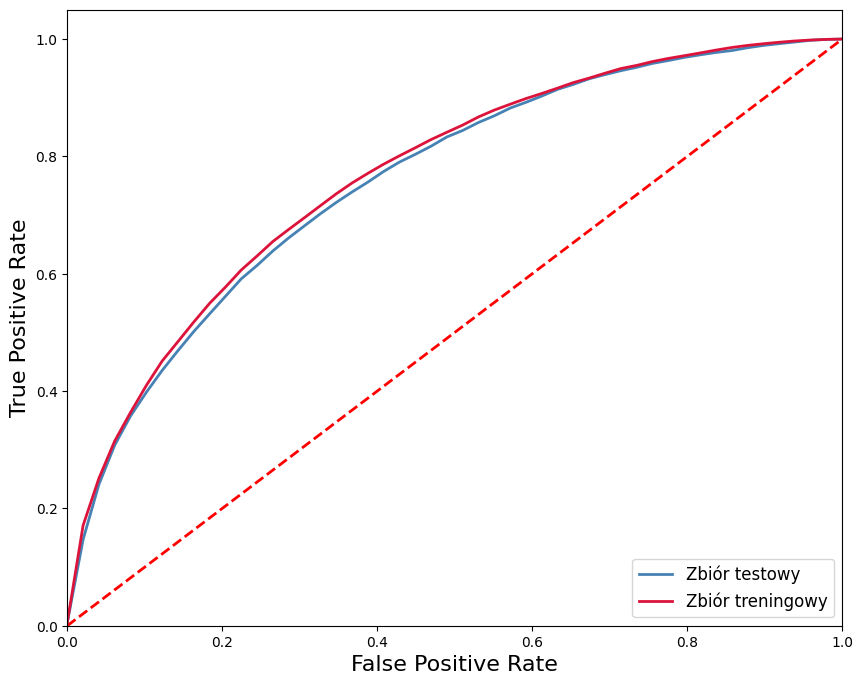

In [23]:
# ROC for test and train sets

y_pred_proba_forest = best_forest.predict_proba(X_test_forest)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_forest)
y_pred_proba_train = best_forest.predict_proba(X_train_forest)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)

# Interpolating points to smoothen the curve.
fpr_new = np.linspace(fpr.min(), fpr.max(), 50)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_new)
fpr_new_train = np.linspace(fpr_train.min(), fpr_train.max(), 50)
tpr_interp_train = interp1d(fpr_train, tpr_train, kind='linear')(fpr_new_train)

plt.figure(figsize=(10, 8))
plt.plot(fpr_new, tpr_interp, color='steelblue', lw=2, label='Zbiór testowy')
plt.plot(fpr_new_train, tpr_interp_train, color='crimson', lw=2, label='Zbiór treningowy')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

Neural network

In [24]:
y_pred_proba_ann = best_model_ann.predict(X_test_ann)
y_pred_proba_ann_train = best_model_ann.predict(X_train_ann)

# Coverting probabilities to binary classes.
y_pred = (y_pred_proba_ann > 0.50).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix - Neural Network:")
display(cm_df)

# Precision, recall, F1:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Confusion Matrix - Neural Network:


,Predicted Negative,Predicted Positive
Actual Negative,4479,2125
Actual Positive,2012,4592


Precision: 0.684
Recall: 0.695
F1-score: 0.689


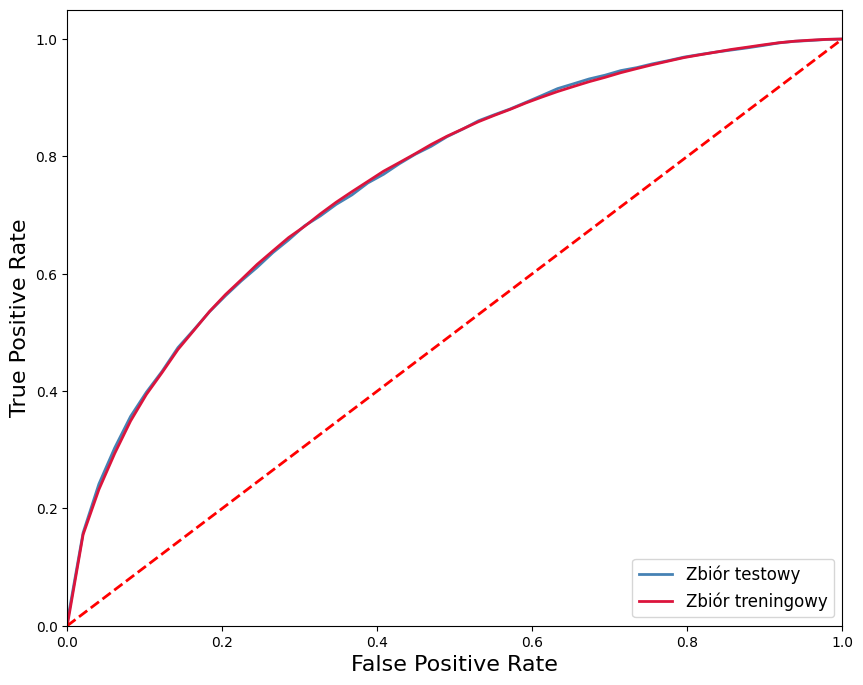

In [25]:
# ROC for test and train sets

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ann)
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_ann_train)

# Interpolating points to smoothen the curve.
fpr_new = np.linspace(fpr.min(), fpr.max(), 50)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_new)
fpr_new_train = np.linspace(fpr_train.min(), fpr_train.max(), 50)
tpr_interp_train = interp1d(fpr_train, tpr_train, kind='linear')(fpr_new_train)

plt.figure(figsize=(10, 8))
plt.plot(fpr_new, tpr_interp, color='steelblue', lw=2, label='Zbiór testowy')
plt.plot(fpr_new_train, tpr_interp_train, color='crimson', lw=2, label='Zbiór treningowy')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

Choosing model

In [216]:
# Removing "losers" from train and test sets. Leaving only one representation for every match ("winners").
X_train_only_wins_log_reg = X_train_log_reg2.loc[y_train == 1]
X_test_only_wins_log_reg = X_test_log_reg2.loc[y_test == 1]
X_train_only_wins_forest_ann = X_train_forest.loc[y_train == 1]
X_test_only_wins_forest_ann = X_test_forest.loc[y_test == 1]
y_train_only_wins = y_train.loc[y_train == 1]
y_test_only_wins = y_test.loc[y_test == 1]

# Adding one case of label "0" for both datasets. Otherwise, Python won't let compile the code. Validation functions require at least 2 different labels.
# One case in such big dataset won't influence results so I can use this trick to avoid causing error.
y_train_only_wins.iloc[0] = 0
y_test_only_wins.iloc[0] = 0

def model_evaluation(model, Xs, Ys=[y_train_only_wins, y_test_only_wins]):
    evaluate_list = []
    for x, y in zip(Xs, Ys):
        y_pred = model.predict_proba(x)[:, 1]
        evaluate_list.append(model.score(x, y))
        evaluate_list.append(log_loss(y, y_pred))
    return evaluate_list

# Evaluation for logistic regression and random forest.
eval_log_reg = model_evaluation(best_log_reg, [X_train_only_wins_log_reg, X_test_only_wins_log_reg])
eval_forest = model_evaluation(best_forest, [X_train_only_wins_forest_ann, X_test_only_wins_forest_ann])

# Evaluation for neural network.
eval_ann = []
ann_evaluation_train = best_model_ann.evaluate(X_train_only_wins_forest_ann, y_train_only_wins)[::-1]
eval_ann.extend(ann_evaluation_train)
y_prob_train = best_model_ann.predict(X_train_only_wins_forest_ann)
ann_evaluation_test = best_model_ann.evaluate(X_test_only_wins_forest_ann, y_test_only_wins)[::-1]
eval_ann.extend(ann_evaluation_test)
y_prob_test = best_model_ann.predict(X_test_only_wins_forest_ann)

# Displaying statistics as DataFrame.
test_results = pd.DataFrame({'Logistic regression': eval_log_reg, 'Random forest': eval_forest, 'Neural network': eval_ann})
test_results.index = ['Accuracy (train)', 'Logistic loss (train)', 'Accuracy (test)', 'Logistic loss (test)']
display(test_results.round(3))

827/827 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6958 - loss: 0.5951
827/827 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6945 - loss: 0.5936
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Logistic regression,Random forest,Neural network
Accuracy (train),0.687,0.694,0.696
Logistic loss (train),0.585,0.575,0.596
Accuracy (test),0.690,0.687,0.695
Logistic loss (test),0.582,0.582,0.596
